In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# svg, png. no inline pdf.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns

In [4]:
import numpy as np
import scipy
import scipy.stats
import pandas

In [5]:
import sklearn
import sklearn.decomposition
import sklearn.feature_extraction
import sklearn.feature_extraction.text

In [6]:
import collections
from pprint import pprint
import cPickle as pickle
import unicodecsv as csv
import json
import re

In [7]:
import analysis_tools

In [8]:
np.seterr(divide='raise', over='raise', under='raise', invalid='raise');

# Data preparation

Let's load the cities. We'll filter out any groups that weren't 'active' during the period of study (2012-2014, inclusive). Active groups are those that have had an event with at least two attendees.

In [9]:
all_city2groups = analysis_tools.get_city2groups('GB')

In [10]:
print "number of groups without city", len(all_city2groups.get('<unknown>', []))
if '<unknown>' in all_city2groups:
    del all_city2groups['<unknown>']

num_grps_before_filter = sum(len(groups) for groups in all_city2groups.itervalues())
print "number of groups before filtering:", num_grps_before_filter

number of groups without city 47
number of groups before filtering: 1541


In [11]:
def is_active(grp):
    for event in grp['events_in_window']:
        if len(event['attendee_ids']) >= 2:
            return True
    return False
        
for city_ident in all_city2groups.iterkeys():
    all_city2groups[city_ident] = filter(is_active, all_city2groups[city_ident])
    
num_grps_after_filter = sum(len(groups) for groups in all_city2groups.itervalues())
print "number of groups after filtering:", num_grps_after_filter

number of groups after filtering: 1230


How many usable groups do we have per city?

In [12]:
group_counts = collections.Counter({city: len(groups) for city, groups in all_city2groups.iteritems()})

for indx, (k, v) in enumerate(group_counts.most_common(25)):
    print "%-10s%-10s%-30s(pop %d)" % (indx+1, v, k, k.pop)
print "..."

1         768       UK::London                    (pop 12972492)
2         56        UK::Bristol metropolitan area (pop 1059746)
3         50        UK::Manchester metropolitan area(pop 2460991)
4         42        UK::Cambridge                 (pop 361461)
5         41        UK::Birmingham metropolitan area(pop 3621263)
6         32        UK::Edinburgh                 (pop 214846)
7         29        UK::Oxford                    (pop 311481)
8         25        UK::Brighton/Worthing/Littlehampton(pop 566617)
9         19        UK::Leeds - Bradford metropolitan area(pop 2210426)
10        15        UK::Belfast                   (pop 857106)
11        14        UK::Cardiff and South Wales valleys metropolitan area(pop 1142941)
12        13        UK::Liverpool/Birkenhead metropolitan area(pop 2060653)
13        12        UK::Leicester                 (pop 747425)
14        10        UK::Tyneside metropolitan area(pop 1399594)
15        9         UK::Nottingham-Derby metropolitan are

In [13]:
min_num_groups = 5
keep_cities = [city for city, count in group_counts.iteritems() if count >= min_num_groups]

print "%d cities with at least %s Tech groups:" % (len(keep_cities), min_num_groups)
print ', '.join(map(str, keep_cities))

city2groups = {city: all_city2groups[city] for city in keep_cities}  # all cities for study

20 cities with at least 5 Tech groups:
UK::Norwich, UK::Birmingham metropolitan area, UK::Belfast, UK::Liverpool/Birkenhead metropolitan area, UK::Oxford, UK::Edinburgh, UK::Portsmouth/Southampton metropolitan area, UK::Tyneside metropolitan area, UK::London, UK::Manchester metropolitan area, UK::Glasgow, UK::Leicester, UK::Cambridge, UK::Cardiff and South Wales valleys metropolitan area, UK::Brighton/Worthing/Littlehampton, UK::Bristol metropolitan area, UK::Nottingham-Derby metropolitan area, UK::Exeter, UK::Leeds - Bradford metropolitan area, UK::Sheffield metropolitan area


In [14]:
num_study_grps = sum(len(groups) for groups in city2groups.itervalues())
print "groups crawled (before filtering)                  ", num_grps_before_filter
print "active groups (after filtering)                    ", num_grps_after_filter
print "active groups in active cities (focus on analysis) ", num_study_grps

groups crawled (before filtering)                   1541
active groups (after filtering)                     1230
active groups in active cities (focus on analysis)  1172


### Build dataframe with descriptors of each city

In [15]:
# city name; longitude; latitude;
# population (geodemographic); num users subscribed (unique); num users attended event (unique)
# num events; num meetup groups



def extract_active_users(groups):
    # active = attended at least one event
    uniqs = set()
    for group in groups:
        for event in group['events_in_window']:
            uniqs.update(event['attendee_ids'])
    return tuple(uniqs)
def count_active_users(groups):
    return len(extract_active_users(groups))

def extract_subscribed_users(groups):
    # subscribed = subscribed to at least one group
    uniqs = set()
    for group in groups:
        uniqs.update(group['member_ids'])
    return tuple(uniqs)
def count_subscribed_users(groups):
    return len(extract_subscribed_users(groups))

rows = []
for city, groups in city2groups.iteritems():
    row = collections.OrderedDict()
    pop = float(city.pop)
    row['name'] = str(city)
    row['lon'] = city.lon
    row['lat'] = city.lat
    row['pop'] = pop
    row['groups'] = float(len(groups))
        # by way of previous filtering, these are 'active' gruops -- at least one event
        # with two attendees
    row['users_members'] = float(count_subscribed_users(groups))
    row['users_attendees'] = float(count_active_users(groups))
    # population-normed measures:
    row['groups_per_100k'] = row['groups'] / (pop/10**5)
    row['users_members_per_100k'] = row['users_members'] / (pop/10**5)
    row['users_attendees_per_100k'] = row['users_attendees'] / (pop/10**5)
    rows.append(row)

df_cities = pandas.DataFrame(rows, columns=rows[0].keys())
print df_cities

                                                 name       lon        lat  \
0              UK::Leeds - Bradford metropolitan area -1.625681  53.845583   
1   UK::Cardiff and South Wales valleys metropolit... -3.252051  51.588511   
2                 UK::Brighton/Worthing/Littlehampton -0.165454  50.858044   
3                                         UK::Glasgow -4.340771  55.870583   
4                                       UK::Leicester -1.098805  52.642711   
5                                          UK::Exeter -3.537374  50.761519   
6          UK::Liverpool/Birkenhead metropolitan area -2.833608  53.366300   
7                                          UK::Oxford -1.291842  51.783367   
8                                       UK::Edinburgh -3.128971  55.873162   
9                                         UK::Norwich  1.286582  52.658770   
10                      UK::Bristol metropolitan area -2.547128  51.445594   
11                   UK::Manchester metropolitan area -2.207738 

### Other data for future reference

In [16]:
# canonical ordering of cities:
all_cities = tuple(sorted(city2groups.iterkeys()))

# Geography of meetups and activity

In [17]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

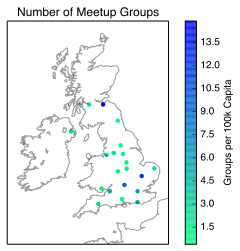

In [18]:
fig, ax = plt.subplots(1, 1)

# use mercator
basem = Basemap(llcrnrlon=-11.372070, llcrnrlat=48.507377, urcrnrlon=2.5, urcrnrlat=59.7,
            rsphere=(6378137.00, 6356752.3142),
            resolution='i', projection='merc',
            lat_0=40., lon_0=-20., lat_ts=20.)

# background and ornaments
basem.drawcoastlines(color=[0, 0, 0, 0.4])
#basem.fillcontinents()

# meridians
#basem.drawmeridians(np.arange(-180,180,30),labels=[1,1,0,1])

ax.set_title('Number of Meetup Groups');

#
# add points

x, y = basem(df_cities['lon'].values, df_cities['lat'].values)
mags = df_cities['groups_per_100k'].values
sc = basem.scatter(x, y, s=20, marker='o', linewidths=0, c=mags, cmap='winter_r')  # 'RdYlBu' 'winter'

cbar = plt.colorbar(sc)
cbar.set_label('Groups per 100k Capita')

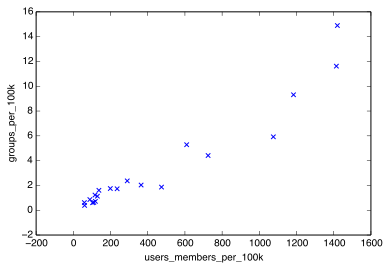

In [19]:
# population, number of groups, number of (unique) active usres (by event attendance)

df_cities.plot(kind='scatter', x='users_members_per_100k', y='groups_per_100k', marker='x')
#, s=df_cities['users_attendees']

# Co-visiting

In [20]:
print "DELETE THIS"

# unique users who've attended an event in city A
# unique users who've attended an event in both city A and city B
# why does this happen? another place has more expertise?
# your own city is missing a meetup on a particular topic?
# we'll restrict ourselves to users who've *attended* events in
# both cities
# other factors: geographic distance, transport
# other caveats: triangle effect (lives in London, visits Oxf and Camb)

N = len(all_cities)
matrix_covisitors = np.zeros([N, N], np.float64)

covis_counts = collections.Counter()  # citya, cityb -> num co-visitors
vis_counts = {}  # city -> num co-visitors

for indx_i, city_i in enumerate(all_cities):
    users_i = frozenset(extract_active_users(city2groups[city_i]))
    vis_counts[city_i] = float(len(users_i))
    
    for indx_j, city_j in enumerate(all_cities):
        if indx_i == indx_j:
            continue
        users_j = frozenset(extract_active_users(city2groups[city_j]))
        num_covisitors = float(len(users_i & users_j))
        
        matrix_covisitors[indx_i,indx_j] = num_covisitors
        if indx_i < indx_j:
            covis_counts[(city_i,city_j)] = num_covisitors

assert np.all(matrix_covisitors == matrix_covisitors.T)

DELETE THIS


In [21]:
for (city_i, city_j), c in covis_counts.most_common(8):
    print c, city_i, " /// ", city_j

547.0 UK::London  ///  UK::Cambridge
546.0 UK::London  ///  UK::Brighton/Worthing/Littlehampton
454.0 UK::London  ///  UK::Bristol metropolitan area
431.0 UK::London  ///  UK::Oxford
293.0 UK::London  ///  UK::Birmingham metropolitan area
263.0 UK::London  ///  UK::Manchester metropolitan area
236.0 UK::London  ///  UK::Tyneside metropolitan area
132.0 UK::Liverpool/Birkenhead metropolitan area  ///  UK::Manchester metropolitan area


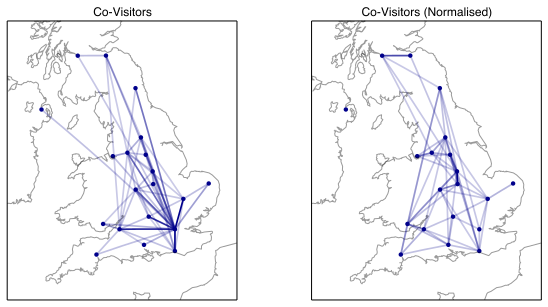

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

#
# Compute city-to-city magnitudes
pairs = []
mags_covisitors = np.zeros([len(covis_counts)], np.float64)  # abs num co-visitors
mags_ratios = np.zeros([len(covis_counts)], np.float64)      # ratio s_ij / m_i * m_j
for indx, (pair, num_covisits) in enumerate(covis_counts.iteritems()):
    cA, cB = pair
    pairs.append(pair)
    mags_covisitors[indx] = num_covisits
    mags_ratios[indx] = num_covisits / (vis_counts[cA] * vis_counts[cB])

#
# Gen params
color = 'darkblue'
percentile = 70
    
#
# General basemap params
params = {'llcrnrlon': -7.372070, 'llcrnrlat': 49.507377, 'urcrnrlon': 2.5, 'urcrnrlat': 56.7}  # all UK
#params = {'llcrnrlon': -5.972070, 'llcrnrlat': 49.807377, 'urcrnrlon': 2.0, 'urcrnrlat': 54.7}  # eng&wal


#
#
# Left-hand plot: raw num covisitors
#

# specifics...
ax = ax1
mags = mags_covisitors

# boilerplate...
basem = Basemap(rsphere=(6378137.00, 6356752.3142), resolution='i',  # c l h f
            projection='merc', lat_0=40., lon_0=-20., lat_ts=20.,
            ax=ax, **params)
basem.drawcoastlines(color=[0, 0, 0, 0.4])

mag_viz_min = np.percentile(mags, percentile)

norm = mpl.colors.Normalize(-max(mags)/4, max(mags))
for (cA, cB), mag in zip(pairs, mags.flat):
    if mag <= mag_viz_min:
        continue
    basem.drawgreatcircle(cA.lon, cA.lat, cB.lon, cB.lat, c=color, alpha=norm(mag), lw=1.7)
ax.set_title('Co-Visitors')


x, y = basem(df_cities['lon'].values, df_cities['lat'].values)
sc = basem.scatter(x, y, s=20, marker='o', linewidths=0, c=color)  # 'RdYlBu' 'winter'

#
#
# Right-hand plot: raw num covisitors
#

# specifics...
ax = ax2
mags = mags_ratios

# boilerplate...
basem = Basemap(rsphere=(6378137.00, 6356752.3142), resolution='i',  # c l h f
            projection='merc', lat_0=40., lon_0=-20., lat_ts=20.,
            ax=ax, **params)
basem.drawcoastlines(color=[0, 0, 0, 0.4])

mag_viz_min = np.percentile(mags, percentile)

norm = mpl.colors.Normalize(-max(mags)/4, max(mags))
for (cA, cB), mag in zip(pairs, mags.flat):
    if mag <= mag_viz_min:
        continue
    basem.drawgreatcircle(cA.lon, cA.lat, cB.lon, cB.lat, c=color, alpha=norm(mag), lw=1.7)
ax.set_title('Co-Visitors (Normalised)')


x, y = basem(df_cities['lon'].values, df_cities['lat'].values)
sc = basem.scatter(x, y, s=20, marker='o', linewidths=0, c=color)  # 'RdYlBu' 'winter'

# Topics, expertise, and similarity

In [ ]:
topic_counts = collections.Counter()

for city, groups in city2groups.iteritems():
    for group in groups:
        num_members = len(group['member_ids'])
        for topic_dict in group['topics']:
            topic_name = topic_dict['name']
            topic_counts[topic_name] += 1    #num_members. not ideal. geodemographic issues. #~

In [ ]:
print "There are %s topics\n" % (len(topic_counts))
for indx, (k, v) in enumerate(topic_counts.most_common(10)):
    print "%-10s%-10s%s" % (indx+1, v, k)
print "..."

Obtain topic count for each city.

In [ ]:
# extract canonical list of topics
topics = tuple(sorted(topic_counts.iterkeys()))

In [ ]:
# build histogram of topics in each city
city2topics = {city: collections.Counter() for city in all_cities}

for city, groups in city2groups.iteritems():
    for group in groups:
        for topic_dict in group['topics']:
            topic_name = topic_dict['name']
            city2topics[city][topic_name] += 1

In [ ]:
# obtain counts
# sigs[row,col] gives the count of occurrences of topic `col` in city `row`
sigs = np.zeros([len(all_cities), len(topics)], dtype=np.float64)
for row, city in enumerate(all_cities):
    for col, topic in enumerate(topics):
        sigs[row,col] = city2topics[city][topic]
print sigs.shape

In [ ]:
# transformations...

# normalise counts (sigs is now normed histogram)
#for row, city in enumerate(all_cities):
#    sigs[row,:] = sigs[row,:] / sigs[row,:].sum()

# or use TFIDF
TFIDF = sklearn.feature_extraction.text.TfidfTransformer()
sigs = TFIDF.fit_transform(sigs).toarray()
print sigs.shape

Let's check some particular examples...

In [ ]:
examples = ['Cardiff', 'Brighton', 'Birmingham']
for part in examples:
    indx_city = None
    for indx, city in enumerate(all_cities):
        if part in unicode(city):
            indx_city = indx
            break
    assert indx_city is not None
    
    pairs = zip(sigs[indx_city,:], topics)
    pairs.sort(reverse=True)
    print city
    print "\t", pairs[:2]
    print "\t", city2topics[city].most_common(2)

### Clustering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import ward, dendrogram

In [ ]:
sim = cosine_similarity(sigs)
dist = 1 - sim

In [ ]:
def top_topics(city_indx, k=3):
    # return the top `k` topics for city all_cities[city_indx]
    pairs = zip(sigs[city_indx,:], topics)
    pairs.sort(reverse=True)
    return [pair[1] for pair in pairs[:k]]

for indx, city in enumerate(all_cities):
    print city, top_topics(indx, k=3)

In [ ]:
#which two cities the most similar according to tf-idf and cosine-similarity?

pair = (np.tril(sim, -1) == np.tril(sim, -1).max()).nonzero()
print "most similar cities:"
print map(str, [all_cities[indx] for indx in pair])

pair = (np.tril(dist, -1) == np.tril(dist, -1).max()).nonzero()
print "least similar cities"
print map(str, [all_cities[indx] for indx in pair])

In [ ]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4)) # set size
dct = dendrogram(linkage_matrix, orientation="right", labels=all_cities, ax=ax1)

ax1.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('topics_tfidf_cosine_dendogram.png', dpi=200)

# list top three topics alongside
#topdown_cities = reversed([all_cities[i] for i in dct['leaves']])
annotations = []
for city_indx in reversed(dct['leaves']):
    city = all_cities[city_indx]
    topics_str = ', '.join(top_topics(city_indx))
    annotations.append(topics_str)
ax2.text(0, 0.5, '\n'.join(annotations), linespacing=1.45, va='center')
ax2.axis('off');

### Similarity visualisation via multi-dimensional scaling

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

X_r = mds.fit_transform(dist)  # shape (n_components, n_samples)

comp1 = X_r[:,0]
comp2 =  X_r[:,1]

fig, ax = plt.subplots(1, 1, figsize=[12,8])
sc = plt.scatter(comp1, comp2, linewidths=0,
                 #cmap='RdYlBu', c=list(lons.flat)
                )  # 'RdYlBu' 'winter'

plt.xlabel('comp 1')
plt.ylabel('comp 2')
plt.title('UK cities')
#cbar = plt.colorbar(sc)
#cbar.set_label('longitude')

for x, y, name in zip(comp1, comp2, all_cities):
    plt.annotate(name, xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])

### Apply PCA

In [ ]:
pca = sklearn.decomposition.PCA(n_components=2)
X_r = pca.fit(sigs).transform(sigs)

print pca.explained_variance_ratio_

In [ ]:
comp1 = X_r[:,0]
comp2 =  X_r[:,1]

fig, ax = plt.subplots(1, 1, figsize=[12,8])
sc = plt.scatter(comp1, comp2, linewidths=0,
                 #cmap='RdYlBu', c=list(lons.flat)
                )  # 'RdYlBu' 'winter'

plt.xlabel('PCA comp 1')
plt.ylabel('PCA comp 2')
plt.title('UK cities')
#cbar = plt.colorbar(sc)
#cbar.set_label('longitude')

for x, y, name in zip(comp1, comp2, all_cities):
    plt.annotate(name, xy=[x, y], fontsize=8, textcoords='offset points', xytext=[2, 0])